The point of this notebook is to:

1. reproject the ASF radiometric and terrain corrected data into a single coordinate reference system.
2. crop the data to a smaller area
3. filter the time series according to month if relevant

In [1]:
import rasterio
from pathlib import Path
from rabasar import reproject_arr_to_match_profile, get_cropped_profile, get_cropped_profile
from tqdm import tqdm
import lxml.etree as etree
import datetime
import numpy as np
import matplotlib.pyplot as plt
import json

# Read Config JSON

In [2]:
config_dict = json.load(open('config.json', 'rb'))
config_dict

{'sensor': 'alos1',
 'site': 'waxlake',
 'regularizer': 'bm3d',
 'spatial_weight': 1.0,
 'temporal_average_spatial_weight': 1.0,
 'ratio_weight': 1.0}

In [3]:
SENSOR = config_dict['sensor']
SITE = config_dict['site']
REGULARIZER = config_dict['regularizer']

# Data Paths

In [4]:
data_dir_path_name = f'{SENSOR}_{SITE}'
DATA_DIR = Path(data_dir_path_name)
DATA_DIR.exists()

True

We name our data directories ready for reprojection in `f'{DATA_DIR}/data_original_tiff'`.

In [5]:
TIF_DIR = Path(f'{DATA_DIR}/data_original_tiff')
TIF_DIR.exists()

True

In [6]:
OUT_DIR = Path(f'{DATA_DIR}/data_reprojected')
OUT_DIR.mkdir(exist_ok=True, parents=True)

In [7]:
image_dirs = sorted(list(TIF_DIR.glob('./*/')))
image_dirs = list(filter(lambda x: x.is_dir(), image_dirs))
image_dirs

[PosixPath('alos1_waxlake/data_original_tiff/AP_09177_FBD_F0580_RT1'),
 PosixPath('alos1_waxlake/data_original_tiff/AP_12532_FBD_F0580_RT1'),
 PosixPath('alos1_waxlake/data_original_tiff/AP_13203_FBD_F0580_RT1'),
 PosixPath('alos1_waxlake/data_original_tiff/AP_13874_FBD_F0580_RT1'),
 PosixPath('alos1_waxlake/data_original_tiff/AP_14545_FBD_F0580_RT1'),
 PosixPath('alos1_waxlake/data_original_tiff/AP_18571_FBD_F0580_RT1'),
 PosixPath('alos1_waxlake/data_original_tiff/AP_19913_FBD_F0580_RT1'),
 PosixPath('alos1_waxlake/data_original_tiff/AP_23268_FBD_F0580_RT1'),
 PosixPath('alos1_waxlake/data_original_tiff/AP_25952_FBD_F0580_RT1')]

In [8]:
hh_paths = sorted(list(TIF_DIR.glob(f'./*/*HH*.tif')))
hv_paths = sorted(list(TIF_DIR.glob(f'./*/*HV*.tif')))
vv_paths = sorted(list(TIF_DIR.glob(f'./*/*VV*.tif')))

hv_paths

[PosixPath('alos1_waxlake/data_original_tiff/AP_09177_FBD_F0580_RT1/AP_09177_FBD_F0580_RT1_HV.tif'),
 PosixPath('alos1_waxlake/data_original_tiff/AP_12532_FBD_F0580_RT1/AP_12532_FBD_F0580_RT1_HV.tif'),
 PosixPath('alos1_waxlake/data_original_tiff/AP_13203_FBD_F0580_RT1/AP_13203_FBD_F0580_RT1_HV.tif'),
 PosixPath('alos1_waxlake/data_original_tiff/AP_13874_FBD_F0580_RT1/AP_13874_FBD_F0580_RT1_HV.tif'),
 PosixPath('alos1_waxlake/data_original_tiff/AP_14545_FBD_F0580_RT1/AP_14545_FBD_F0580_RT1_HV.tif'),
 PosixPath('alos1_waxlake/data_original_tiff/AP_18571_FBD_F0580_RT1/AP_18571_FBD_F0580_RT1_HV.tif'),
 PosixPath('alos1_waxlake/data_original_tiff/AP_19913_FBD_F0580_RT1/AP_19913_FBD_F0580_RT1_HV.tif'),
 PosixPath('alos1_waxlake/data_original_tiff/AP_23268_FBD_F0580_RT1/AP_23268_FBD_F0580_RT1_HV.tif'),
 PosixPath('alos1_waxlake/data_original_tiff/AP_25952_FBD_F0580_RT1/AP_25952_FBD_F0580_RT1_HV.tif')]

# Inspect Profiles

In [9]:
def get_profile(path):
    with rasterio.open(path) as ds:
        p = ds.profile
        p['nodata'] = np.nan
    return p
profiles = [get_profile(p) for p in hh_paths]
profiles

[{'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 6370, 'height': 5627, 'count': 1, 'crs': CRS.from_epsg(32615), 'transform': Affine(12.5, 0.0, 610122.0,
        0.0, -12.5, 3323860.75), 'tiled': False, 'compress': 'packbits', 'interleave': 'band'},
 {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 6368, 'height': 5626, 'count': 1, 'crs': CRS.from_epsg(32615), 'transform': Affine(12.5, 0.0, 611286.9375,
        0.0, -12.5, 3323847.25), 'tiled': False, 'compress': 'packbits', 'interleave': 'band'},
 {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 6372, 'height': 5630, 'count': 1, 'crs': CRS.from_epsg(32615), 'transform': Affine(12.5, 0.0, 608418.0625,
        0.0, -12.5, 3323795.0), 'tiled': False, 'compress': 'packbits', 'interleave': 'band'},
 {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 6372, 'height': 5631, 'count': 1, 'crs': CRS.from_epsg(32615), 'transform': Affine(12.5, 0.0, 606509.9375,
        0.0, -12.5, 3323916.

# Get Dates

In [10]:
def get_uavsar_date(image_path):
    element = image_path.name[23:29]
    date = datetime.date(int('20'+element[:2]), int(element[2:4]), int(element[4:6]))
    return date

def get_alos1_date_from_xml(metadata_xml_path):
    tree = etree.parse(open(metadata_xml_path))
    root = tree.getroot()

    dataAcquisition_elements = root.xpath('//gml:beginPosition', namespaces=root.nsmap)
    assert(len(dataAcquisition_elements) == 1)
    element = dataAcquisition_elements[0].text
    date = datetime.date(int(element[:4]), int(element[5:7]), int(element[8:10]))
    return date

def get_alos1_date(image_path):
    xml_path = list(image_path.parent.glob('*iso.xml'))[0]
    return get_alos1_date_from_xml(str(xml_path))
    
def get_date(image_path):
    if SENSOR == 'uavsar':
        return get_uavsar_date(image_path)
    elif SENSOR == 'alos1':
        return get_alos1_date(image_path)
    else:
        return ValueError('Check `config_dict[\'sensor\']`. Must be uavsar or alos1')

In [11]:
dates = list(map(get_date, hv_paths))
dates

[datetime.date(2007, 10, 15),
 datetime.date(2008, 6, 1),
 datetime.date(2008, 7, 17),
 datetime.date(2008, 9, 1),
 datetime.date(2008, 10, 17),
 datetime.date(2009, 7, 20),
 datetime.date(2009, 10, 20),
 datetime.date(2010, 6, 7),
 datetime.date(2010, 12, 8)]

# Reading 

In [12]:
def read_one(image_path):
    with rasterio.open(image_path) as ds:
        img = ds.read()
        profile = ds.profile
        profile['nodata'] = np.nan

    if SENSOR == 'alos1':
        img[img == 0] = np.nan
    
    img = np.clip(img, 0, 1)
    return img, profile

These are slices selected for each of the study areas. Add as apropriate and test using the subsequent line.

In [13]:
if SITE == 'waxlake' and SENSOR == 'uavsar':
    sy = np.s_[-2000:-1000]
    sx = np.s_[-3000:-2000]
elif SITE == 'waxlake' and SENSOR == 'alos1':
    sy = np.s_[3_900:4_900]
    sx = np.s_[2_800:3_800]
else:
    raise NotImplementedError

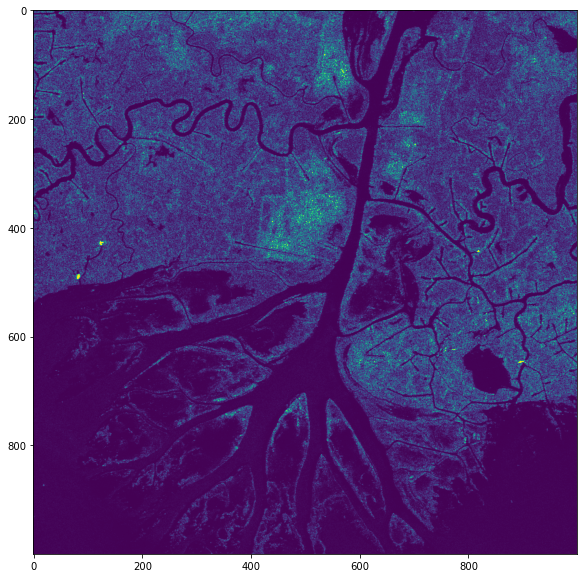

In [14]:
plt.figure(figsize=(10, 10))
arr, _ = read_one(hh_paths[0])
plt.imshow(arr[0, sy, sx], vmax=1)

# Filter by Date

In [15]:
MONTHS_TO_USE = list(range(1, 13))
MONTHS_TO_USE

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

We are removing first index because less coverage.

In [16]:
indices = [k for k, date in enumerate(dates) if date.month in MONTHS_TO_USE]
indices

[0, 1, 2, 3, 4, 5, 6, 7, 8]

In [17]:
hh_paths_filtered = [hh_paths[k] for k in indices]
hv_paths_filtered = [hv_paths[k] for k in indices]
if SENSOR == 'uavsar':
    vv_paths_filtered = [vv_paths[k] for k in indices]

hh_paths_filtered

[PosixPath('alos1_waxlake/data_original_tiff/AP_09177_FBD_F0580_RT1/AP_09177_FBD_F0580_RT1_HH.tif'),
 PosixPath('alos1_waxlake/data_original_tiff/AP_12532_FBD_F0580_RT1/AP_12532_FBD_F0580_RT1_HH.tif'),
 PosixPath('alos1_waxlake/data_original_tiff/AP_13203_FBD_F0580_RT1/AP_13203_FBD_F0580_RT1_HH.tif'),
 PosixPath('alos1_waxlake/data_original_tiff/AP_13874_FBD_F0580_RT1/AP_13874_FBD_F0580_RT1_HH.tif'),
 PosixPath('alos1_waxlake/data_original_tiff/AP_14545_FBD_F0580_RT1/AP_14545_FBD_F0580_RT1_HH.tif'),
 PosixPath('alos1_waxlake/data_original_tiff/AP_18571_FBD_F0580_RT1/AP_18571_FBD_F0580_RT1_HH.tif'),
 PosixPath('alos1_waxlake/data_original_tiff/AP_19913_FBD_F0580_RT1/AP_19913_FBD_F0580_RT1_HH.tif'),
 PosixPath('alos1_waxlake/data_original_tiff/AP_23268_FBD_F0580_RT1/AP_23268_FBD_F0580_RT1_HH.tif'),
 PosixPath('alos1_waxlake/data_original_tiff/AP_25952_FBD_F0580_RT1/AP_25952_FBD_F0580_RT1_HH.tif')]

In [18]:
profiles = [get_profile(p) for p in hh_paths_filtered]
profiles

[{'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 6370, 'height': 5627, 'count': 1, 'crs': CRS.from_epsg(32615), 'transform': Affine(12.5, 0.0, 610122.0,
        0.0, -12.5, 3323860.75), 'tiled': False, 'compress': 'packbits', 'interleave': 'band'},
 {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 6368, 'height': 5626, 'count': 1, 'crs': CRS.from_epsg(32615), 'transform': Affine(12.5, 0.0, 611286.9375,
        0.0, -12.5, 3323847.25), 'tiled': False, 'compress': 'packbits', 'interleave': 'band'},
 {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 6372, 'height': 5630, 'count': 1, 'crs': CRS.from_epsg(32615), 'transform': Affine(12.5, 0.0, 608418.0625,
        0.0, -12.5, 3323795.0), 'tiled': False, 'compress': 'packbits', 'interleave': 'band'},
 {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 6372, 'height': 5631, 'count': 1, 'crs': CRS.from_epsg(32615), 'transform': Affine(12.5, 0.0, 606509.9375,
        0.0, -12.5, 3323916.

In [19]:
REFERENCE_PROFILE = profiles[0].copy()
REFERENCE_PROFILE['driver'] = 'GTiff'
REFERENCE_PROFILE['nodata'] = np.nan
REFERENCE_PROFILE

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 6370, 'height': 5627, 'count': 1, 'crs': CRS.from_epsg(32615), 'transform': Affine(12.5, 0.0, 610122.0,
       0.0, -12.5, 3323860.75), 'tiled': False, 'compress': 'packbits', 'interleave': 'band'}

The regularizer `bm3d` is a very complex regularizer and can take a good deal of time to run even on a `1000 x 1000` image. Thus, we reproject everything into the square selected above.

In [20]:
REFERENCE_PROFILE

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 6370, 'height': 5627, 'count': 1, 'crs': CRS.from_epsg(32615), 'transform': Affine(12.5, 0.0, 610122.0,
       0.0, -12.5, 3323860.75), 'tiled': False, 'compress': 'packbits', 'interleave': 'band'}

In [21]:
if REGULARIZER == 'bm3d':
    REFERENCE_PROFILE = get_cropped_profile(REFERENCE_PROFILE, sx, sy)
REFERENCE_PROFILE

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 1000, 'height': 1000, 'count': 1, 'crs': CRS.from_epsg(32615), 'transform': Affine(12.5, 0.0, 645122.0,
       0.0, -12.5, 3275110.75), 'tiled': False, 'compress': 'packbits', 'interleave': 'band'}

In [22]:
db_lower_bound = -40
db_upper_bound = 0
def clip_image(img):
    lb = np.power(10, db_lower_bound / 10.)
    ub = np.power(10, db_upper_bound / 10.)
    return np.clip(img, lb, ub)

def reproject_one(raster_path):
    img_src, profile_src = read_one(raster_path)
        
    img_r, profile_r = reproject_arr_to_match_profile(img_src, 
                                                      profile_src, 
                                                      REFERENCE_PROFILE, 
                                                      resampling='bilinear')
    img_r = clip_image(img_r)
    return img_r, profile_r

def write_reprojected(img_r, original_raster_path, pol):
    date = get_date(original_raster_path)

    dest_dir = Path(f'{OUT_DIR}/{pol}')
    dest_dir.mkdir(exist_ok=True, parents=True)
    dest_path = dest_dir/f'{SENSOR}_{SITE}_{pol}_RTC_{date.year}{date.month:02d}{date.day:02d}.tif'

    with rasterio.open(dest_path, 'w', **REFERENCE_PROFILE) as ds:
        ds.write(img_r)
    return dest_path

In [23]:
# Returning (img, profile) pair
reprojected_data_hh = list(map(reproject_one, tqdm(hh_paths_filtered)))
# separating images and profiles
reprojected_images_hh, _ = zip(*reprojected_data_hh)

100%|██████████| 9/9 [00:03<00:00,  2.58it/s]


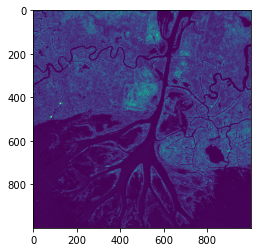

In [24]:
plt.imshow(reprojected_images_hh[0][0,...])

In [25]:
reprojected_data_hv = list(map(reproject_one, tqdm(hv_paths_filtered)))
reprojected_images_hv, _ = zip(*reprojected_data_hv)

100%|██████████| 9/9 [00:02<00:00,  3.17it/s]


In [26]:
if SENSOR == 'uavsar':
    reprojected_data_vv = list(map(reproject_one, tqdm(vv_paths_filtered)))
    reprojected_images_vv, _ = zip(*reprojected_data_vv)

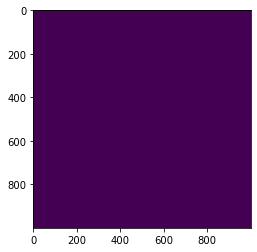

In [27]:
from functools import reduce

mask_ts = [np.isnan(img) for img in reprojected_images_hh]
ts_mask = list(reduce(np.logical_or, mask_ts))[0]

plt.imshow(ts_mask)

In [28]:
def apply_mask(img):
    img_ = img.copy()
    (img_[0,...])[ts_mask] = np.nan
    return img_

In [29]:
reprojected_images_hh = list(map(apply_mask, tqdm(reprojected_images_hh)))
reprojected_images_hv = list(map(apply_mask, tqdm(reprojected_images_hv)))
if SENSOR == 'uavsar':
    reprojected_images_vv = list(map(apply_mask, tqdm(reprojected_images_vv)))

100%|██████████| 9/9 [00:00<00:00, 1158.33it/s]


In [30]:
from itertools import starmap

N = len(hh_paths_filtered)
list(starmap(write_reprojected, tqdm(zip(reprojected_images_hh, hh_paths_filtered, ['hh'] * N), total=N)))

100%|██████████| 9/9 [00:00<00:00, 32.23it/s]


[PosixPath('alos1_waxlake/data_reprojected/hh/alos1_waxlake_hh_RTC_20071015.tif'),
 PosixPath('alos1_waxlake/data_reprojected/hh/alos1_waxlake_hh_RTC_20080601.tif'),
 PosixPath('alos1_waxlake/data_reprojected/hh/alos1_waxlake_hh_RTC_20080717.tif'),
 PosixPath('alos1_waxlake/data_reprojected/hh/alos1_waxlake_hh_RTC_20080901.tif'),
 PosixPath('alos1_waxlake/data_reprojected/hh/alos1_waxlake_hh_RTC_20081017.tif'),
 PosixPath('alos1_waxlake/data_reprojected/hh/alos1_waxlake_hh_RTC_20090720.tif'),
 PosixPath('alos1_waxlake/data_reprojected/hh/alos1_waxlake_hh_RTC_20091020.tif'),
 PosixPath('alos1_waxlake/data_reprojected/hh/alos1_waxlake_hh_RTC_20100607.tif'),
 PosixPath('alos1_waxlake/data_reprojected/hh/alos1_waxlake_hh_RTC_20101208.tif')]

In [31]:
list(starmap(write_reprojected, tqdm(zip(reprojected_images_hv, hv_paths_filtered, ['hv'] * N), total=N)))

100%|██████████| 9/9 [00:00<00:00, 32.82it/s]


[PosixPath('alos1_waxlake/data_reprojected/hv/alos1_waxlake_hv_RTC_20071015.tif'),
 PosixPath('alos1_waxlake/data_reprojected/hv/alos1_waxlake_hv_RTC_20080601.tif'),
 PosixPath('alos1_waxlake/data_reprojected/hv/alos1_waxlake_hv_RTC_20080717.tif'),
 PosixPath('alos1_waxlake/data_reprojected/hv/alos1_waxlake_hv_RTC_20080901.tif'),
 PosixPath('alos1_waxlake/data_reprojected/hv/alos1_waxlake_hv_RTC_20081017.tif'),
 PosixPath('alos1_waxlake/data_reprojected/hv/alos1_waxlake_hv_RTC_20090720.tif'),
 PosixPath('alos1_waxlake/data_reprojected/hv/alos1_waxlake_hv_RTC_20091020.tif'),
 PosixPath('alos1_waxlake/data_reprojected/hv/alos1_waxlake_hv_RTC_20100607.tif'),
 PosixPath('alos1_waxlake/data_reprojected/hv/alos1_waxlake_hv_RTC_20101208.tif')]

In [32]:
if SENSOR == 'uavsar':
    list(starmap(write_reprojected, tqdm(zip(reprojected_images_vv, vv_paths_filtered, ['vv'] * N), total=N)))

# Copy DEM

In [33]:
dem_path = list(image_dirs[0].glob('*dem*.tif'))[0]
with rasterio.open(dem_path) as ds:
    if REGULARIZER == 'bm3d':
        dem = ds.read(1).astype('float32')[sy, sx]
    else:
        dem = ds.read(1).astype('float32')
    dem[ts_mask] = np.nan

In [34]:
with rasterio.open(OUT_DIR/'dem.tif', 'w', **REFERENCE_PROFILE) as ds:
    ds.write(dem, 1)